# Actor Critic Project
Victor Micha, Fares Boudelaa

##############
NOTES, TO BE REMOVED
we are doing online actor critic, meaning that the actor-critic is updated at each step, not at each end of episode



FOR REPORT
- mention we can compare shared NN vs 2 NN for actor critic 
- mention we could do continuous action spaces too
- could compare with eligibility tracees and without
- Asyncronous Advantage Actor Critic (A3C) (LOOK AT SLIDES)
    A3C: multiple independent agents (own parameters) interacting with a    different copy
    of the environment in parallel; asynchronously.
    After n steps, update, then reset parameters to those of the global network.
##############

## Setup

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import cast
#import pandas as pd
#import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)

mps


In [3]:
########## TO BE ABLE TO RUN AND VISUALIZE EPISODE GIVEN AN AGENT #############

from IPython.display import Video
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from pathlib import Path


def run_and_display_episode(agent, env_name="CartPole-v1", video_title="vid-name"):
    """
    Run an episode with the given agent and display it as a video.
    
    Args:
        agent: Trained ActorCriticNetwork instance
        env_name: Gymnasium environment name (default: "CartPole-v1")
        video_title: Prefix for the video file name (default: "vid-name")
        max_steps: Maximum steps to run the episode (default: 500)
    """
    # Set up video directory
    VIDS_DIR = Path("./videos")
    VIDS_DIR.mkdir(parents=True, exist_ok=True)  # Simplified directory creation

    # Define video path
    video_filename = f"{video_title}-episode-0.mp4"
    video_path = VIDS_DIR / video_filename
    video_path.unlink(missing_ok=True)  # Clean up any existing file

    # Create and wrap environment
    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(
        env,
        video_folder=str(VIDS_DIR),
        name_prefix=video_title,
        episode_trigger=lambda x: x == 0  # Record only first episode
    )

    # Run episode
    state, info = env.reset()
    done = False
    step = 0
    while not done:
        action, _, _ = agent.policy(state)  # Unpack tuple explicitly
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        step += 1
    
    # Finalize and display
    env.close()
    print(f"Episode ran for {step} steps")  # Confirm length
    display(Video(
        str(video_path),
        embed=True,
        html_attributes="controls autoplay loop"
    ))

## Continuous State Space + Discrete Action Space

In [4]:
gymnasium_environments = [
    "CartPole-v1",
    "MountainCar-v0",
    "Acrobot-v1"
]

In [5]:
# CHOOSE ENV TO PLAY WITH
env_name = gymnasium_environments[0]

In [6]:
env = gym.make(env_name, render_mode="rgb_array")
    
# Get observation and action spaces
observation_space = env.observation_space
action_space = env.action_space

# assert observation space is continuous (Box)
assert isinstance(observation_space, gym.spaces.Box), f"{env_name} observation space is not continuous (Box)."
    
# assert action space is discrete (Discrete)
assert isinstance(action_space, gym.spaces.Discrete), f"{env_name} action space is not discrete (Discrete)."

# to be used later
observation_dim = observation_space.shape[0]  # Number of *dimensions* in the observation space (i.e. number of *elements* in the observation vector)
num_actions = action_space.n.item()

print(f"\nEnvironment: {env_name}")
print("Observation Space:")
print(f"  Type: {type(observation_space)}")
print(f"  Dimensions: {observation_dim}")  # Number of dimensions
print(f"  Low: {observation_space.low}")
print(f"  High: {observation_space.high}")
    

print("Action Space:")
print(f"  Type: {type(action_space)}")
print(f"  Number of actions: {num_actions}")  # Number of discrete actions


env.close()


Environment: CartPole-v1
Observation Space:
  Type: <class 'gymnasium.spaces.box.Box'>
  Dimensions: 4
  Low: [-4.8               -inf -0.41887903        -inf]
  High: [4.8               inf 0.41887903        inf]
Action Space:
  Type: <class 'gymnasium.spaces.discrete.Discrete'>
  Number of actions: 2


### Actor-Critic Model with Eligibility Traces

#### 1 NN: Shared backbone for actor and critic + two heads (one for the actor, one for the critic)

In [7]:
class ActorCriticNetwork(nn.Module):
    """
    For Continuous State Space + Discrete Action Space
    """
    def __init__(
        self,
        observation_dim,      # Dimension of the input state (e.g., 4 for CartPole)
        num_actions,          # Number of discrete actions (e.g., 2 for CartPole)
        shared_hidden_size=128,  # Hidden size for shared backbone layers
        actor_hidden_size=64,    # Hidden size for actor head layers
        critic_hidden_size=64    # Hidden size for critic head layers
    ):
        super(ActorCriticNetwork, self).__init__()
        
        assert observation_dim > 0, "Observation dimension must be positive"
        assert num_actions > 0, "Number of actions must be positive"

        # Shared backbone: Fixed 2-layer Sequential
        self.shared_backbone = nn.Sequential(
            nn.Linear(observation_dim, shared_hidden_size),
            nn.ReLU(),
            nn.Linear(shared_hidden_size, shared_hidden_size),
            nn.ReLU()
        )
        
        # Actor head: 2-layer MLP (shared_hidden_size -> actor_hidden_size -> num_actions)
        self.actor_layer1 = nn.Linear(shared_hidden_size, actor_hidden_size)
        self.actor_layer2 = nn.Linear(actor_hidden_size, num_actions)
        
        # Critic head: 2-layer MLP (shared_hidden_size -> critic_hidden_size -> 1)
        # critic estimates 1D value of V(s) for policy given by actor
        self.critic_layer1 = nn.Linear(shared_hidden_size, critic_hidden_size)
        self.critic_layer2 = nn.Linear(critic_hidden_size, 1)
        
        self.num_actions = num_actions

        self.to(device)
    
    def forward(self, state):
        """
        Forward pass: Takes a state and returns action probabilities and value.
        
        Args:
            state (torch.Tensor): Shape [batch_size, observation_dim]
        
        Returns:
            action_probs (torch.Tensor): Shape [batch_size, num_actions] (softmax probs)
            value (torch.Tensor): Shape [batch_size, 1] (state value)
        """
        state = state.to(device)
        
        x = self.shared_backbone(state)
        
        # Actor head
        actor_x = F.relu(self.actor_layer1(x))
        actor_logits = self.actor_layer2(actor_x)
        action_probs = F.softmax(actor_logits, dim=-1)  # Softmax over actions
        
        # Critic head
        critic_x = F.relu(self.critic_layer1(x))
        value = self.critic_layer2(critic_x)  # No activation, raw value
        
        return action_probs, value

    def policy(self, state, verbose=False):
        """
        Sample an action from the policy given a state.
        
        Args:
            state (torch.Tensor): Shape [observation_dim] or [1, observation_dim]
        
        Returns:
            action (int): Sampled action
            log_prob (torch.Tensor): Log probability of the action
            entropy (torch.Tensor): Entropy of the action distribution
        """
        # Convert NumPy array to PyTorch tensor if needed
        if isinstance(state, np.ndarray):
            state = torch.from_numpy(state).float()
        
        # Ensure state is a 2D tensor [1, observation_dim] for batch processing
        if state.dim() == 1:
            state = state.unsqueeze(0)
         
        # Get action probabilities and value
        action_probs, _ = self.forward(state)
        
        # Sample action using a categorical distribution
        dist = torch.distributions.Categorical(action_probs)
        
        action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()  # entropy to incite exploration
        if verbose:
            print(f"Action probs: {action_probs} Entropy: {entropy}")
        
        return action.item(), log_prob, entropy

#example usage
agent = ActorCriticNetwork(
    observation_dim=observation_dim,
    num_actions=num_actions
)

# random state for testing
state = torch.randn(1, observation_dim)  # Batch of 1
action_probs, value = agent(state)
print("Action probabilities:", action_probs)  # [1, 2]
print("Value estimate:", value)               # [1, 1]
    
# sample an action
action, log_prob, entropy = agent.policy(state)
print(f"Sampled action: {action}, Log prob: {log_prob}, entropy: {entropy}")

Action probabilities: tensor([[0.4936, 0.5064]], device='mps:0', grad_fn=<SoftmaxBackward0>)
Value estimate: tensor([[0.0283]], device='mps:0', grad_fn=<LinearBackward0>)
Sampled action: 0, Log prob: tensor([-0.7061], device='mps:0', grad_fn=<SqueezeBackward1>), entropy: tensor([0.6931], device='mps:0', grad_fn=<NegBackward0>)


#### Try untrained agent

In [8]:
agent = ActorCriticNetwork(
    observation_dim=observation_dim,
    num_actions=num_actions
)
run_and_display_episode(agent, env_name=env_name, video_title="untrained_agent")

/Users/victormicha/PythonProjects/IP_Paris/AdvMLAutonomousAgents_EP/ActorCriticProject/actor_critic_env/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/victormicha/PythonProjects/IP_Paris/AdvMLAutonomousAgents_EP/ActorCriticProject/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode ran for 11 steps


#### Train the Agent

In [9]:
def train_actor_critic_with_traces(
    agent,                # Pre-initialized ActorCriticNetwork
    env_name="CartPole-v1",
    num_episodes=1000,    # Number of episodes to train
    gamma=0.99,           # Discount factor
    lambda_theta=0.9,     # Trace-decay rate for actor
    lambda_w=0.9,         # Trace-decay rate for critic
    alpha_theta=0.001,    # Learning rate for actor
    alpha_w=0.001,        # Learning rate for critic
    entropy_beta=0.01     # entropy weight
    # a higher entropy beta penalize distributions with low entropy like 0 1 or 1 0, which make agent always pick same choice
):


    assert lambda_theta<1 and lambda_theta>0
    assert lambda_w<1 and lambda_w>0
    
    env = gym.make(env_name)
    
    actor_params = list(agent.actor_layer1.parameters()) + list(agent.actor_layer2.parameters())
    critic_params = list(agent.critic_layer1.parameters()) + list(agent.critic_layer2.parameters())
    shared_params = list(agent.shared_backbone.parameters())
    
    optimizer_theta = optim.Adam(actor_params + shared_params, lr=alpha_theta)
    optimizer_w = optim.Adam(critic_params + shared_params, lr=alpha_w)
    
    episode_rewards = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        z_theta = [torch.zeros_like(p, device=device) for p in (actor_params + shared_params)]
        z_w = [torch.zeros_like(p, device=device) for p in (critic_params + shared_params)]
        I = 1.0
        total_reward = 0
        done = False
        step = 0
        
        while not done:
            action, log_prob, entropy = agent.policy(state, verbose=episode==0 or episode==num_episodes-1)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
            
            state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
            next_state_tensor = torch.from_numpy(next_state).float().unsqueeze(0).to(device)
            _, value = agent(state_tensor)
            _, next_value = agent(next_state_tensor)
            if done:
                next_value = torch.zeros_like(next_value, device=device)
            delta = reward + gamma * next_value - value
            delta = delta.squeeze(0)
            delta_item = delta.item()
            
            # Compute losses
            value_loss = delta.pow(2)
            actor_loss = -log_prob * delta.detach() - entropy_beta * entropy
            
            # Compute gradients without updating parameters yet
            optimizer_w.zero_grad()
            value_loss.backward(retain_graph=True)  # Retain graph for actor
            critic_grads = [param.grad.clone() if param.grad is not None else torch.zeros_like(param, device=device) 
                          for param in (critic_params + shared_params)]
            
            optimizer_theta.zero_grad()
            actor_loss.backward()
            actor_grads = [param.grad.clone() if param.grad is not None else torch.zeros_like(param, device=device) 
                         for param in (actor_params + shared_params)]
            
            # Update eligibility traces
            for i, (param, grad) in enumerate(zip(critic_params + shared_params, critic_grads)):
                z_w[i] = gamma * lambda_w * z_w[i] + grad
                param.grad = z_w[i] * delta_item
            
            for i, (param, grad) in enumerate(zip(actor_params + shared_params, actor_grads)):
                z_theta[i] = gamma * lambda_theta * z_theta[i] + I * grad
                param.grad = z_theta[i] * delta_item

            if episode==0 or episode==num_episodes-1:
                print(f"Value Loss: {value_loss.item()}, Actor Loss: {actor_loss.item()}")
            
            # Apply updates after both backward passes
            optimizer_w.step()
            optimizer_theta.step()
            
            I = gamma * I
            state = next_state
            step += 1
        
        episode_rewards.append(total_reward)
        if episode % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:]) if episode >= 10 else total_reward
            print(f"Episode {episode}, Total Reward: {total_reward}, Avg Reward (last 10): {avg_reward:.2f}")
    
    env.close()
    return episode_rewards

mps
Action probs: tensor([[0.5411, 0.4589]], device='mps:0', grad_fn=<SoftmaxBackward0>) Entropy: tensor([0.6898], device='mps:0', grad_fn=<NegBackward0>)
Value Loss: 0.9490308165550232, Actor Loss: 0.6898273825645447
Action probs: tensor([[0.5375, 0.4625]], device='mps:0', grad_fn=<SoftmaxBackward0>) Entropy: tensor([0.6903], device='mps:0', grad_fn=<NegBackward0>)
Value Loss: 0.941443681716919, Actor Loss: 0.5333731174468994
Action probs: tensor([[0.5373, 0.4627]], device='mps:0', grad_fn=<SoftmaxBackward0>) Entropy: tensor([0.6904], device='mps:0', grad_fn=<NegBackward0>)
Value Loss: 0.9474039077758789, Actor Loss: 0.6810736060142517
Action probs: tensor([[0.5346, 0.4654]], device='mps:0', grad_fn=<SoftmaxBackward0>) Entropy: tensor([0.6908], device='mps:0', grad_fn=<NegBackward0>)
Value Loss: 0.9487483501434326, Actor Loss: 0.6759324073791504
Action probs: tensor([[0.5321, 0.4679]], device='mps:0', grad_fn=<SoftmaxBackward0>) Entropy: tensor([0.6911], device='mps:0', grad_fn=<NegBa

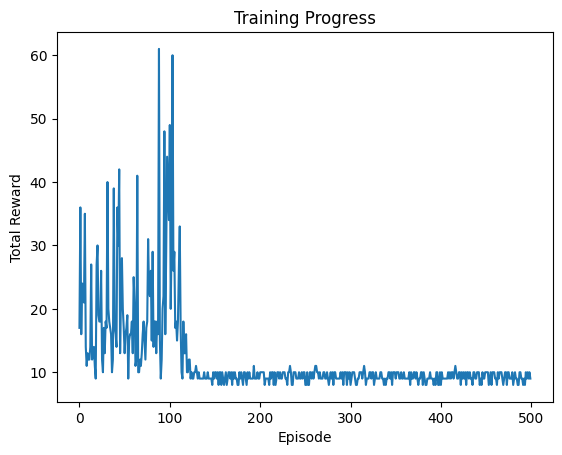

In [10]:
# Initialize agent
agent = ActorCriticNetwork(
    observation_dim=observation_dim,
    num_actions=num_actions,
    shared_hidden_size=16,
    actor_hidden_size=8,
    critic_hidden_size=8
)

print(device)
# Train the agent
rewards = train_actor_critic_with_traces(
    agent=agent,
    env_name=env_name,
    num_episodes=500,#1000
    gamma=0.9,
    lambda_theta=0.7,# in (0,1)
    lambda_w=0.7,# in (0,1)
    alpha_theta=0.001,
    alpha_w=0.001,
    entropy_beta=0.1 # 0.1
)
    
# Plot rewards
    
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress")
plt.show()

#### Try Trained Agent

In [11]:
run_and_display_episode(agent, env_name=env_name, video_title="trained_agent")

/Users/victormicha/PythonProjects/IP_Paris/AdvMLAutonomousAgents_EP/ActorCriticProject/actor_critic_env/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/victormicha/PythonProjects/IP_Paris/AdvMLAutonomousAgents_EP/ActorCriticProject/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode ran for 10 steps


# NOTES

In [12]:
# TODO, DEBUG THE TRAIN FIUNCTION, NEED TO MAKE SURE PSEUDOCODE IS WELL FOLLOWED + THE SHAPES MUST MATCH
# COULD ADD COMMENTS TO EACH LINE OF CODE WITHT THE CORREESPONDING LINE OF PSEUDOCODE
# COULD TEST THE POLICY IN THE TRAINING LOOP FOR A FEW EPISODES, USING MODELTRAIN AND EVAL OF COURSE AND KEEPING TRACK OF THE AVG RETURN PER EPISODE (LIKE IN LAB6)

In [13]:
# to fix problem of action probs shifting to 1, 0 or 0,1 for all states (so only 1 action is sampled), we need a counterforce to encourage exploration
# Without a counterforce, this becomes a feedback loop: the favored action gets reinforced, probabilities skew further, and exploration dies.
#Entropy Term: -beta * entropy penalizes low-entropy distributions (like [1.0, 0.0]), pushing action_probs toward a more balanced spread (e.g., [0.7, 0.3]).

#Exploration: Forces the agent to try both actions, allowing it to discover better policies (e.g., balancing the pole by alternating left and right).

"""
LOSSES:
optimizing π(A∣S,θ)
 to maximize future rewards, guided by δ
 Actor: Updates π using δ as a signal of action quality, plus entropy for exploration.



The critic’s job is to approximate the true value function Vπ(s)
. The TD error δ
 is the difference between the "expected" value (based on reward and next state) and the "actual" value.
value_loss = delta.pow(2)  # δ²
Minimizing δ2
 adjusts www
 to make v^(S,w)
 closer to r+γv^(S′,w), consistent with supervised regression


actor_loss = -log_prob * delta.detach() - entropy_beta * entropy
This isn’t a "loss" in the supervised sense (expected - actual), but an objective to maximize:
Policy Gradient Term: -log_prob * delta approximates −∇θJ(θ), where J(θ)J is the expected cumulative reward. 
Positive δ: Action was better than expected → increase π(A∣S,θ)\pi(A|S, \theta)\pi(A|S, \theta)
 (reduce -log_prob).

Negative δ: Action was worse → decrease π(A∣S,θ) (increase -log_prob).
We negate it because optimizers minimize loss, but we want to maximize reward.

Entropy Term: -entropy_beta * entropy encourages exploration.
Low entropy (e.g., [1, 0]) → small negative term → higher loss → penalizes determinism.
High entropy (e.g., [0.5, 0.5]) → larger negative term → lower loss → encourages diversity.



"""

'\nLOSSES:\noptimizing π(A∣S,θ)\n to maximize future rewards, guided by δ\n Actor: Updates π using δ as a signal of action quality, plus entropy for exploration.\n\n\n\nThe critic’s job is to approximate the true value function Vπ(s)\n. The TD error δ\n is the difference between the "expected" value (based on reward and next state) and the "actual" value.\nvalue_loss = delta.pow(2)  # δ²\nMinimizing δ2\n adjusts www\n to make v^(S,w)\n closer to r+γv^(S′,w), consistent with supervised regression\n\n\nactor_loss = -log_prob * delta.detach() - entropy_beta * entropy\nThis isn’t a "loss" in the supervised sense (expected - actual), but an objective to maximize:\nPolicy Gradient Term: -log_prob * delta approximates −∇θJ(θ), where J(θ)J is the expected cumulative reward. \nPositive δ: Action was better than expected → increase π(A∣S,θ)\\pi(A|S, \theta)\\pi(A|S, \theta)\n (reduce -log_prob).\n\nNegative δ: Action was worse → decrease π(A∣S,θ) (increase -log_prob).\nWe negate it because optim